In [311]:
#########################################
# Classify NFL NFC West Team Logos images
#########################################

# Note:
# run with Python 3.6; tensorflow 2.0

#References:
# https://www.tensorflow.org/tutorials/images/classification
# https://www.tensorflow.org/tutorials/images/cnn
# https://www.tensorflow.org/api_docs/python/tf/keras

In [312]:
##################
# import packages
##################
from __future__ import absolute_import, division, print_function, unicode_literals

In [313]:
import tensorflow as tf

In [314]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

In [315]:
from shutil import copy

In [ ]:
import IPython.display as display
from PIL import Image

In [316]:
######################
# import images
#####################
import pathlib
data_dir = '<your path>\\Images'
data_dir = pathlib.Path(data_dir)

In [317]:
#images - 2653 total
len_images = len(list(data_dir.glob('*/*.jpg')))

In [318]:
len_images

2653

In [319]:
#classes
classes = ['Cardinals', 'FortyNiners', 'Rams', 'Seahawks']

In [320]:
###########################
#split into train/test
###########################
model_dir = '<your path>\\ModelImages'

In [51]:
# Note: run only once

###############################
split_value = .33

for i in classes:
    temp_dir = '<your path>\\Images\\' + i
    temp_dir = pathlib.Path(temp_dir)
    #print(temp_dir)
    
    #get len and path
    image_paths = list(temp_dir.glob('*.jpg'))
    len_images = len(image_paths)
    #print(len_images)
    
    #create split
    split_array = np.random.rand(1,len_images)
    
    #copy files in train/test
    for j in range(0,len_images):
        src = image_paths[j]
        if split_array[0][j] > split_value:
            dst = model_dir + '\\Train\\' + i
            dst = pathlib.Path(dst)
        else:
            dst = model_dir + '\\Test\\' + i
            dst = pathlib.Path(dst)
        copy(src, dst)
        #print(src)
        
########################

In [321]:
# get total train
model_dir_train = model_dir + '\\Train'
model_dir_train = pathlib.Path(model_dir_train)
model_dir_train
total_train = len(list(model_dir_train.glob('*/*.jpg')))
total_train

1765

In [322]:
# get total val
model_dir_test = model_dir + '\\Test'
model_dir_test = pathlib.Path(model_dir_test)
model_dir_test
total_val = len(list(model_dir_test.glob('*/*.jpg')))
total_val

888

In [323]:
#create paths to folders for training/test
train_dir = os.path.join(model_dir, 'Train')
validation_dir = os.path.join(model_dir, 'Test')

In [324]:
###################
# Train Model
##################
#set up variables
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [325]:
# get data

# References:
# https://keras.io/preprocessing/image/#flow_from_directory
# https://keras.io/preprocessing/image/#imagedatagenerator-class
# note: can use validation_split in image generator to create training/validation split

#Data augmentation
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=False, #True,
                    #zoom_range=0.5
                    )

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [326]:
#generate train images
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode='rgba',
                                                           class_mode='categorical')

Found 1765 images belonging to 4 classes.


In [327]:
#generate validation images
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode='rgba',
                                                              class_mode='categorical')

Found 888 images belonging to 4 classes.


In [328]:
#visualize data
sample_training_images, _ = next(train_data_gen)

In [329]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

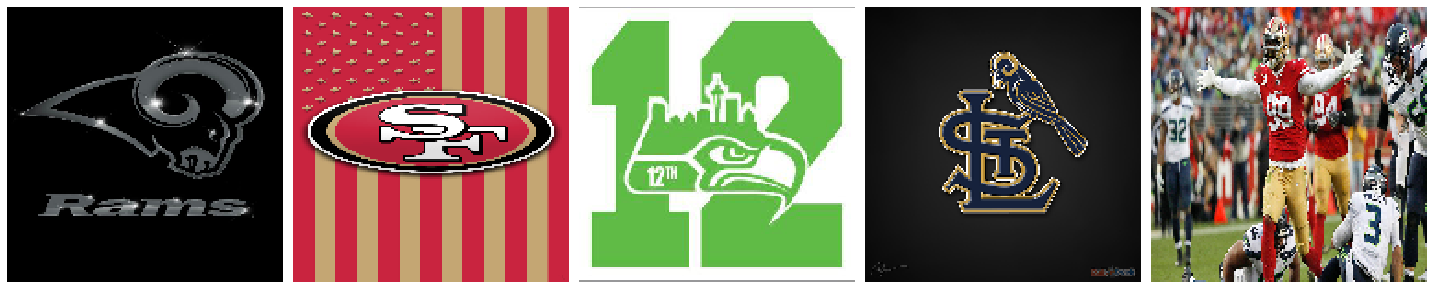

In [330]:
#plot images
plotImages(sample_training_images[:5])

In [331]:
# build model
# Note: input shape = 3 if using rgb, 4 if using rgba
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,4)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='softmax')
])

In [332]:
# set learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=(total_train // batch_size)*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [333]:
# complile
model.compile( optimizer = get_optimizer(), #optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [334]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 150, 150, 16)      592       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 18, 18, 64)      

In [335]:
#early stopping
# Reference : https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            restore_best_weights=True,
                                            patience=10) # the validation loss for X consecutive epochs

In [336]:
# History of Results:
#  original: 15 epochs: 58s 4s/step - loss: 0.0360 - accuracy: 0.9933 - val_loss: 0.4543 - val_accuracy: 0.8906
# add dropouts: 15 epochs: 97s 7s/step - loss: 0.2081 - accuracy: 0.9279 - val_loss: 0.3926 - val_accuracy: 0.8529
# 25 epochs: 90s 7s/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.4366 - val_accuracy: 0.8958
# 15 epochs with Data Aug: 82s 6s/step - loss: 0.6383 - accuracy: 0.6988 - val_loss: 0.7231 - val_accuracy: 0.6979
# 25 epochs, remove flip, early stopping : 85s 7s/step - loss: 0.5676 - accuracy: 0.7472 - val_loss: 0.5101 - val_accuracy: 0.8164
# 25 epochs, early stop, learning schedule, L2: 82s 6s/step - loss: 0.5823 - accuracy: 0.8082 - val_loss: 0.5240 - val_accuracy: 0.8411
# 100 epochs, early stop, learning schedule, L2: stopped at 57: 108s 8s/step - loss: 0.4120 - accuracy: 0.8760 - val_loss: 0.4338 - val_accuracy: 0.8828
#100 epochs, early stop, learning schedule, L2, no data aug: stopped at 52: 77s 6s/step - loss: 0.1240 - accuracy: 0.9896 - val_loss: 0.4087 - val_accuracy: 0.9049

history = model.fit_generator(
    train_data_gen,
    callbacks=[callback],
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/100
13/13 [==============================] - 207s 16s/step - loss: 3.4555 - accuracy: 0.2841 - val_loss: 1.8956 - val_accuracy: 0.4766
Epoch 2/100
13/13 [==============================] - 201s 15s/step - loss: 1.6651 - accuracy: 0.4997 - val_loss: 1.4266 - val_accuracy: 0.6159
Epoch 3/100
13/13 [==============================] - 206s 16s/step - loss: 1.3418 - accuracy: 0.6237 - val_loss: 1.3653 - val_accuracy: 0.5768
Epoch 4/100
13/13 [==============================] - 114s 9s/step - loss: 1.1150 - accuracy: 0.7115 - val_loss: 1.0351 - val_accuracy: 0.7539
Epoch 5/100
13/13 [==============================] - 98s 8s/step - loss: 0.9844 - accuracy: 0.7569 - val_loss: 1.0706 - val_accuracy: 0.7122
Epoch 6/100
13/13 [==============================] - 98s 8s/step - loss: 0.8566 - accuracy: 0.7905 - val_loss: 0.8960 - val_accuracy: 0.7812
Epoch 7/100
13/13 [==============================] - 90s 7s/step - loss: 0.6914 - accuracy: 0.8742 - val_loss: 0.7818 - val_accuracy: 0.8112
Epoch 

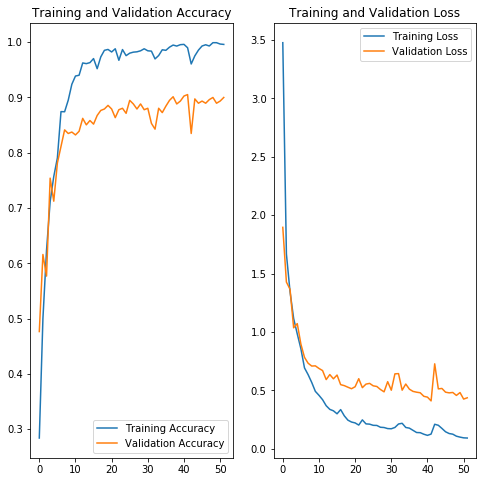

In [337]:
# visualize results
#Reference: https://www.tensorflow.org/tutorials/images/classification#visualize_training_results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(52)#range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
#save model
# Reference: https://www.tensorflow.org/tutorials/keras/save_and_load

# Save the entire model
#keras_model_path = "<your path>\keras_save"
#keras_model_path = "<your path>\keras_save_noDataAug"

#model.save(keras_model_path)  # save()

In [2]:
# Recreate the exact same model, including its weights and the optimizer
#restored_keras_model = tf.keras.models.load_model(keras_model_path)
#restored_keras_model.fit(train_dataset, epochs=2)

# Show the model architecture
#restored_keras_model.summary()

In [340]:
#####################
# view misclassified images
#####################
# References:
# https://stackoverflow.com/questions/44740479/image-classification-with-keras-on-tensorflow-how-to-find-which-images-are-misc
# https://github.com/keras-team/keras/issues/3296

#predict training data with model, no shuffle
train_data_gen_predict = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=False, #change to False for prediction
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode='rgba',
                                                           class_mode='categorical')
train_data_gen_predict.reset()
predicted = model.predict_generator(train_data_gen_predict)

Found 1765 images belonging to 4 classes.


In [342]:
# get correct labels
correctLabels = train_data_gen_predict.classes

In [399]:
#get correct class indices
class_indices = train_data_gen_predict.class_indices
class_indices

{'Cardinals': 0, 'FortyNiners': 1, 'Rams': 2, 'Seahawks': 3}

In [345]:
#create prediction label list
prediction_list = []
for i in predicted:
    column = 0
    max_value = i[0]
    if i[1]>max_value:
        max_value = i[1]
        column = 1
    if i[2]>max_value:
        max_value = i[2]
        column = 2
    if i[3]>max_value:
        max_value = i[3]
        column = 3
    prediction_list = prediction_list + [column]

In [347]:
# number of incorrect predictions: 7
sum(correctLabels != prediction_list)

7

In [348]:
# accuracy of prediction on training data: 99.6%
sum(correctLabels == prediction_list) / len(correctLabels)

0.9960339943342776

In [356]:
#get indices for incorrect predictions
res = [i for i, val in enumerate(correctLabels != prediction_list) if val]

In [374]:
#get misclassified image filenames
misclassified = [train_data_gen_predict.filenames[i] for i in res]

In [384]:
#get full path to misclassified images
misclassified_fullpath = [os.path.join(train_dir, x) for x in misclassified]

In [398]:
#get prediction labels
prediction_labels = [prediction_list[i] for i in res]

[0, 1, 0, 1, 3, 1, 1]

In [402]:
#get classes
classes = ['Cardinals', 'FortyNiners', 'Rams', 'Seahawks']

In [416]:
# get prediction classes
prediction_classes=[classes[x] for x in prediction_labels]

Cardinals


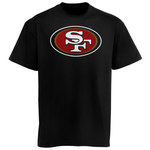

FortyNiners


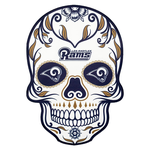

Cardinals


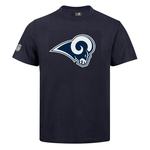

FortyNiners


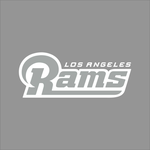

Seahawks


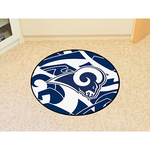

FortyNiners


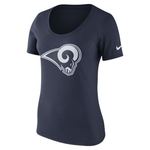

FortyNiners


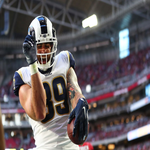

In [418]:
#display misclassified images with prediction class labels
for i in range(0,len(misclassified_fullpath)):
    print(prediction_classes[i])
    display.display(Image.open(str(misclassified_fullpath[i])).resize((IMG_WIDTH,IMG_HEIGHT), Image.ANTIALIAS))

In [ ]:
# end